<a href="https://colab.research.google.com/github/ixvqc/praca-magisterska/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Macierz pomyłek (Test):
[[914 121]
 [175 199]]
  Prawdziwie Pozytywne (TP) (churn): 199
  Fałszywie Pozytywne (FP) (churn): 121
  Prawdziwie Negatywne (TN) (non-churn): 914
  Fałszywie Negatywne (FN) (churn): 175
Accuracy: 0.7899
Recall: 0.5321
Precision: 0.6219
F1-score: 0.5735
AUROC: 0.8263


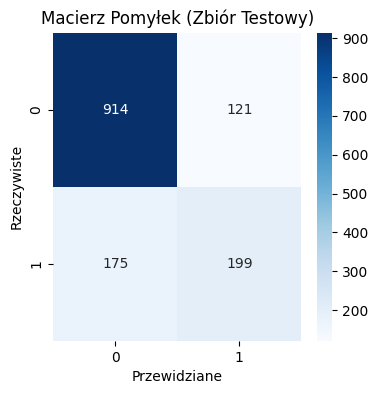

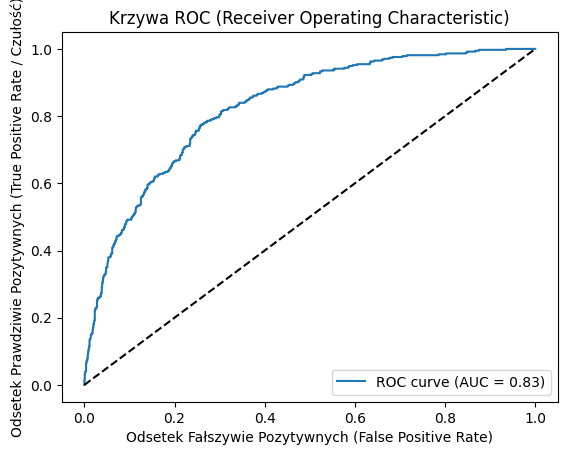

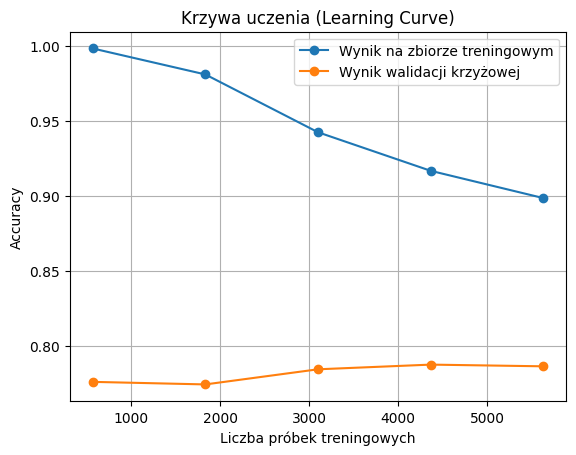

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 2. Kodowanie cech kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 3. Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 4. Podział na X i y
X = df.drop(columns=['Churn'])
y = df['Churn']

# 5. Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Standaryzacja cech numerycznych
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 7. Trening
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# 8. Ewaluacja na zbiorze testowym
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
recall_churn = tp / (tp + fn) if (tp + fn) > 0 else 0.0
precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn) if (precision_churn + recall_churn) > 0 else 0.0
auroc = roc_auc_score(y_test, y_proba)

print("Macierz pomyłek (Test):")
print(cm)
print(f"  Prawdziwie Pozytywne (TP) (churn): {tp}")
print(f"  Fałszywie Pozytywne (FP) (churn): {fp}")
print(f"  Prawdziwie Negatywne (TN) (non-churn): {tn}")
print(f"  Fałszywie Negatywne (FN) (churn): {fn}")

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall_churn:.4f}")
print(f"Precision: {precision_churn:.4f}")
print(f"F1-score: {f1_churn:.4f}")
print(f"AUROC: {auroc:.4f}")

# 9. Wykresy

# 9.1. Macierz pomyłek
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek (Zbiór Testowy)')
plt.show()

# 9.2. Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek Fałszywie Pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (True Positive Rate / Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()


# 9.4. Krzywa uczenia
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy'
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Wynik na zbiorze treningowym')
plt.plot(train_sizes, test_mean, 'o-', label='Wynik walidacji krzyżowej')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Accuracy')
plt.title('Krzywa uczenia (Learning Curve)')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82      1035
           1       0.53      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.76      0.77      1409

Accuracy: 0.7565649396735273
Pole pod krzywą ROC (AUC): 0.8265971737838745
Macierz pomyłek:
 [[803 232]
 [111 263]]
Czułość: 0.703
scale_pos_weight użyty w modelu: 2.768561872909699


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Macierz pomyłek (walidacja krzyżowa):
 [[3991 1183]
 [ 522 1347]]


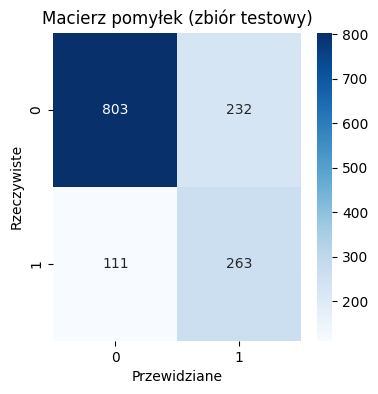

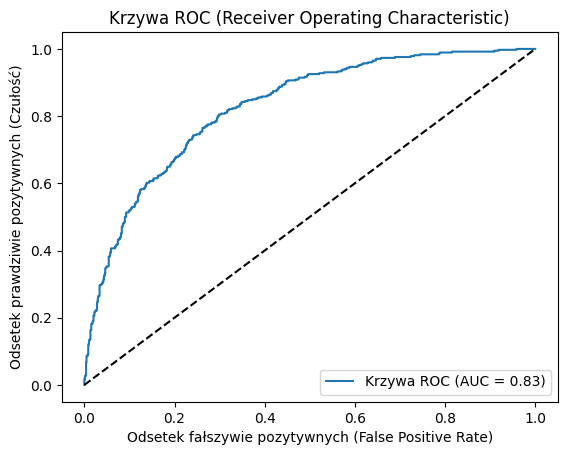

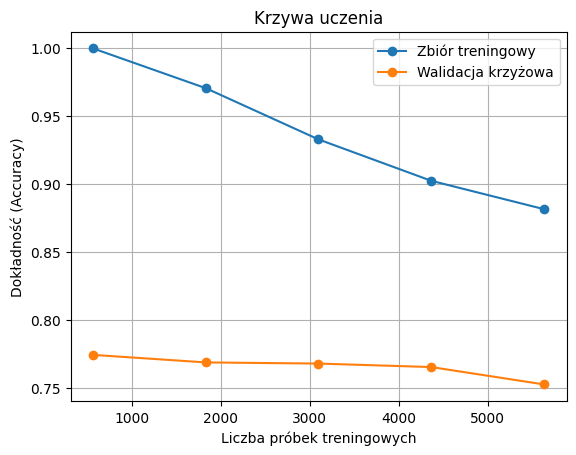

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, confusion_matrix,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve, roc_curve, auc
)
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Kodowanie cech kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Wyznaczanie scale_pos_weight
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

# Trening
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Ewaluacja
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Pole pod krzywą ROC (AUC):", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

# Czułość
tn, fp, fn, tp = cm.ravel()
czulosc = tp / (tp + fn)

print(f"Czułość: {czulosc:.3f}")

print("scale_pos_weight użyty w modelu:", scale_pos_weight)

# --- Macierz pomyłek cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X, y, cv=cv)
cm_cv = confusion_matrix(y, y_pred_cv)
print("Macierz pomyłek (walidacja krzyżowa):\n", cm_cv)

# --- Wykresy ---

# Macierz pomyłek
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek (zbiór testowy)')
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek fałszywie pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek prawdziwie pozytywnych (Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

# Krzywa uczenia
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Zbiór treningowy')
plt.plot(train_sizes, test_mean, 'o-', label='Walidacja krzyżowa')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Dokładność (Accuracy)')
plt.title('Krzywa uczenia')
plt.legend()
plt.grid()
plt.show()

Przed SMOTE: [4139 1495]
Po SMOTE:    [4139 4139]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1035
           1       0.59      0.60      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

Dokładność (accuracy): 0.7856635911994322
Pole pod krzywą ROC (AUC): 0.8274225632281899
Macierz pomyłek:
 [[881 154]
 [148 226]]
Czułość (Recall klasy 1): 0.604


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Macierz pomyłek (walidacja krzyżowa):
 [[4576  598]
 [ 883  986]]


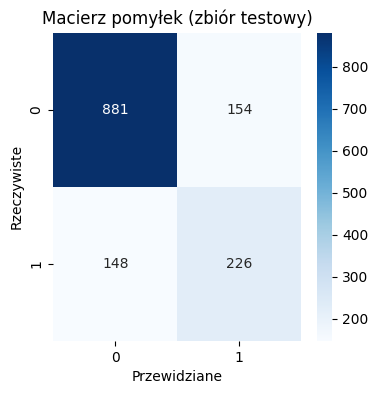

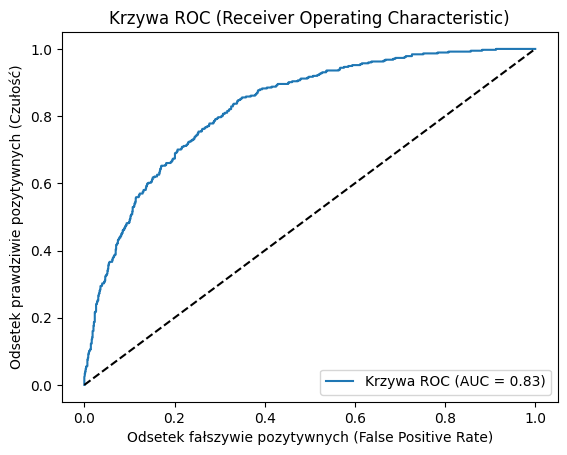

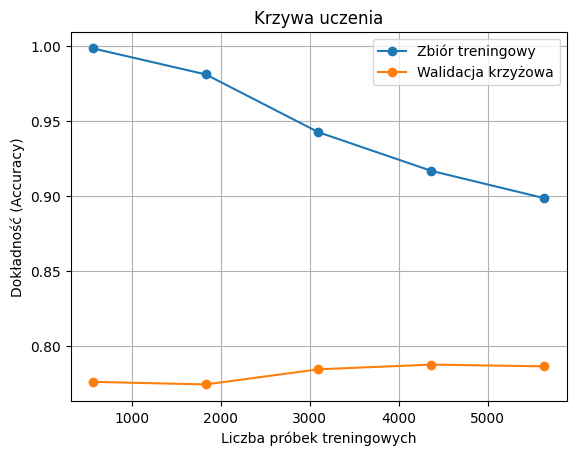

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Kodowanie cech kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

X = df.drop(columns=['Churn'])
y = df['Churn']

# Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standaryzacja
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# SMOTE - oversampling klasy mniejszościowej na train
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Przed SMOTE:", np.bincount(y_train))
print("Po SMOTE:   ", np.bincount(y_train_sm))

# Trening
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_sm, y_train_sm)

# Ewaluacja
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))
print("Dokładność (accuracy):", accuracy_score(y_test, y_pred))
print("Pole pod krzywą ROC (AUC):", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

# Czułość (recall klasy 1)
tn, fp, fn, tp = cm.ravel()
czulosc = tp / (tp + fn)

print(f"Czułość (Recall klasy 1): {czulosc:.3f}")

# --- Macierz pomyłek cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X, y, cv=cv)
cm_cv = confusion_matrix(y, y_pred_cv)
print("Macierz pomyłek (walidacja krzyżowa):\n", cm_cv)

# --- Wykresy ---

# Macierz pomyłek
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek (zbiór testowy)')
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek fałszywie pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek prawdziwie pozytywnych (Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

# Krzywa uczenia
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Zbiór treningowy')
plt.plot(train_sizes, test_mean, 'o-', label='Walidacja krzyżowa')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Dokładność (Accuracy)')
plt.title('Krzywa uczenia')
plt.legend()
plt.grid()
plt.show()